# Dependency tree via autonomous categories
> see
> - https://ncatlab.org/nlab/show/dependency+grammar
> - https://arxiv.org/pdf/1411.3827.pdf
> 
> for relevant theory

In [1]:
import spacy; nlp = spacy.load("en_core_web_sm")

tree_doc = nlp("This is my dependency tree!")
sentence = next(tree_doc.sents)

sentence2 = next(nlp("The quick brown fox jumps over the lazy dog.").sents)

In [2]:
from spacy import displacy

displacy.render(tree_doc, style="dep")


# Step 1 - Cups only, "≤" boxes
- word order is kept track of by (invisible) input wires to words at the top of the diagram

#### ≤ Boxes:
- when a word has children in the dependency tree, it is connected to the input of a "≤" box:
    - one output wire of the same grammatical type to connect to either an ancestor in the tree or to diagram output
    - dependent children to left in sentence connected by right adjoint output wires
    - dependent children to right connected by left adjoint output wires
- leaves of the tree are just words
- dependency structure encoded in cups

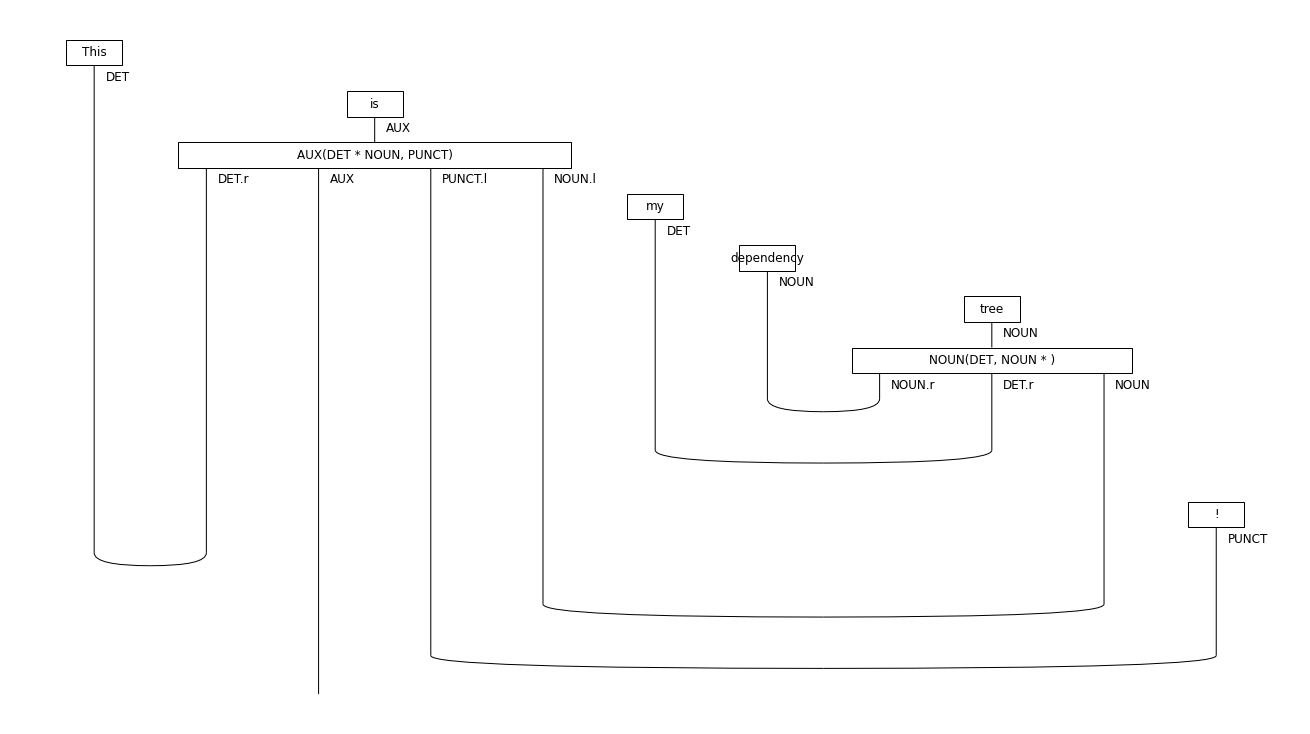

In [3]:
from discopy import Ty, Word, Id, Box, Cup

def autonomous_tree_nocaps(token):
    
    # recursion - base case
    if token.n_lefts + token.n_rights == 0:
        return Word(token.text, Ty(token.pos_))


    # recursion - self-reference
    # top layer - word, box and subtree
    left_cod  = [Ty(l.pos_).r for l in token.lefts]
    left_cod.reverse()
    right_cod = [Ty(r.pos_).l for r in token.rights]
    right_cod.reverse()
    
    cod = left_cod + [Ty(token.pos_)] + right_cod
    cod = Ty().tensor(*cod)
    
    left_label  = ", ".join([l.pos_ for l in token.lefts])
    right_label = ", ".join([r.pos_ for r in token.rights])
    
    label = f"{token.pos_}({left_label} * {right_label})"
    box = Box(label, Ty(token.pos_), cod)
    
    top_layer = Word(token.text, Ty(token.pos_)) >> box
    
    # subtree
    left_subtree  = Id(Ty()).tensor(*[autonomous_tree_nocaps(l) for l in token.lefts])
    right_subtree = Id(Ty()).tensor(*[autonomous_tree_nocaps(r) for r in token.rights])
    
    top_layer = left_subtree @ top_layer @ right_subtree
    
    
    # bottom layer - cups and one Id
    left_cups  = [Cup(l.l, l) for l in reversed(left_cod)]
    right_cups = [Cup(r, r.r) for r in right_cod]
    
    bottom_left = Id(Ty())
    left_wires  = Id(Ty())
    right_wires = Id(Ty())
    for cup in left_cups:
        new = left_wires @ cup @ right_wires
        bottom_left = new >> bottom_left
        left_wires  = left_wires @ Id(Ty(cup.dom[0]))
        right_wires = Id(Ty(cup.dom[1])) @ right_wires
        
    bottom_right = Id(Ty())
    left_wires   = Id(Ty())
    right_wires  = Id(Ty())
    for cup in right_cups:
        new = left_wires @ cup @ right_wires
        bottom_right = new >> bottom_right
        left_wires   = left_wires @ Id(Ty(cup.dom[0]))
        right_wires  = Id(Ty(cup.dom[1])) @ right_wires
    
    bottom_layer = bottom_left @ Id(Ty(token.pos_)) @ bottom_right

    
    return top_layer >> bottom_layer
    
diagram = autonomous_tree_nocaps(sentence.root)
diagram.draw(figsize=(18,10))

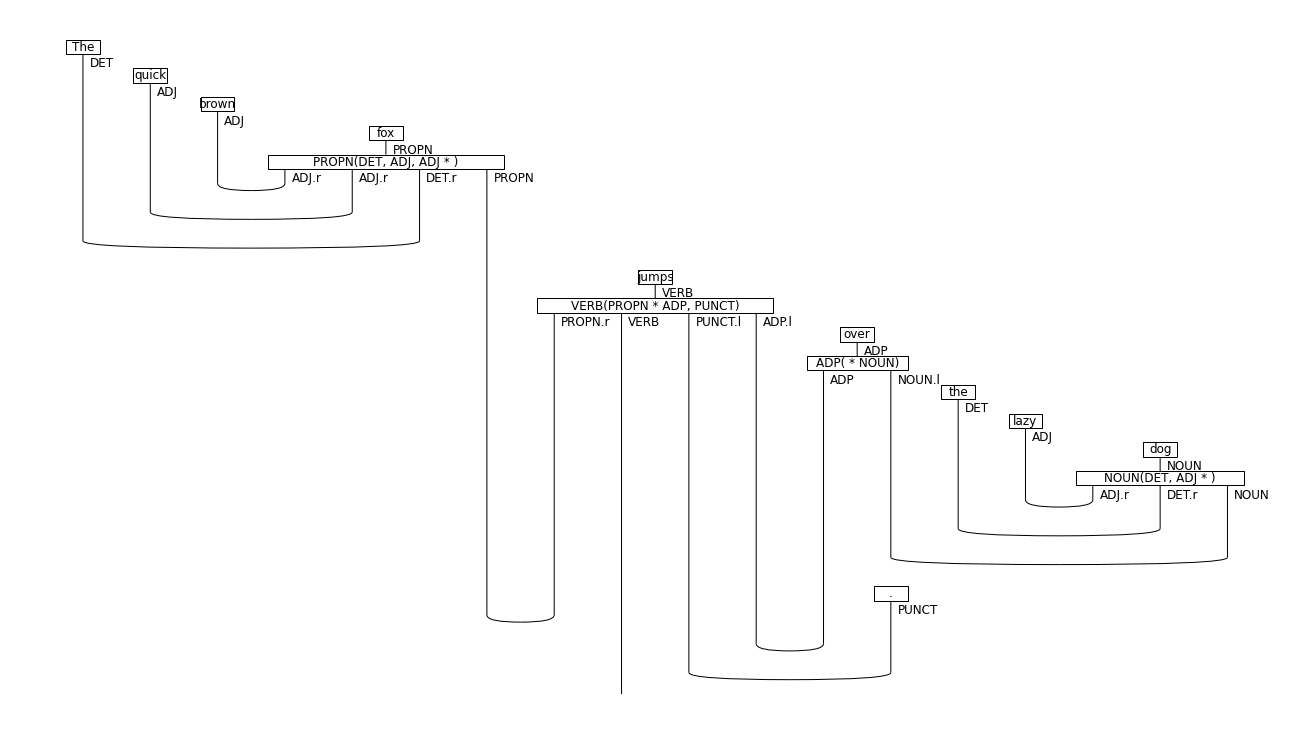

In [4]:
diagram2 = autonomous_tree_nocaps(sentence2.root)
diagram2.draw(figsize=(18,10))

# Step 2 - Functor to add caps 
To follow the construction in https://arxiv.org/pdf/1411.3827.pdf (figure 1). The arrow mapping is defined by `add_caps_box`

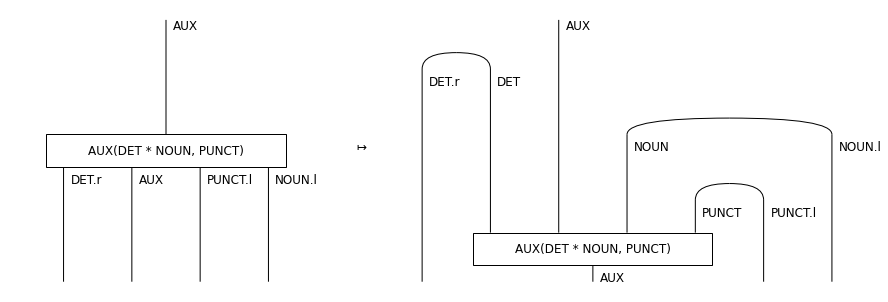

In [5]:
from discopy import Cup, Cap, Functor, drawing

def add_caps_box(box):
    left = Id(Ty())
    right = Id(Ty())
    dom = Ty()
    rdom = Ty()
    cod = Ty()
    l = None
    m = Id(Ty())
    r = None
    for i, obj in enumerate(box.cod):
        if obj.z == 1:
            dom = Ty(obj.name) @ dom
            left = left @ Id(Ty(obj.name).r)
            if not l:
                l = Cap(Ty(obj.name).r, Ty(obj.name))
            else:
                l =  l >> Id(box.cod[:i]) @ Cap(Ty(obj.name).r, Ty(obj.name)) @ Id(Ty()).tensor(*reversed([Id(Ty(obj.name)) for obj in box.cod[:i].objects]))
        elif obj.z == 0:
            dom = dom @ Ty(obj.name)
            cod = cod @ Ty(obj.name)
            m = m @ Id(Ty(obj.name))
        elif obj.z == -1:
            rdom = Ty(obj.name) @ rdom
            right = right @ Id(Ty(obj.name).l)
            if not r:
                r =  Id(Ty()).tensor(*reversed([Id(Ty(obj.name)) for obj in box.cod[i+1:].objects])) @ Id(box.cod[i+1:])\
                >> Id(Ty()).tensor(*reversed([Id(Ty(obj.name)) for obj in box.cod[i+1:].objects])) @ Cap(Ty(obj.name), Ty(obj.name).l) @ Id(box.cod[i+1:])
            else:
                r = Id(Ty()).tensor(*reversed([Id(Ty(obj.name)) for obj in box.cod[i+1:].objects])) @ Cap(Ty(obj.name), Ty(obj.name).l) @ Id(box.cod[i+1:]) >> r
    
    dom = dom @ rdom
    full = m
    if l: full = l @ full
    if r: full = full @ r
    if box.dom != Ty():
        full = full >> (left @ Box(box.name, dom, cod) @ right)
    else:
        full = box >> full

    return full

box = diagram.boxes[2]
drawing.equation(box, add_caps_box(box), symbol="$\mapsto$", figsize=(12,4))

# Step 3 - Apply functor, followed by snake removal

- object mapping is given by the identity map (spaCy types to spaCy types)

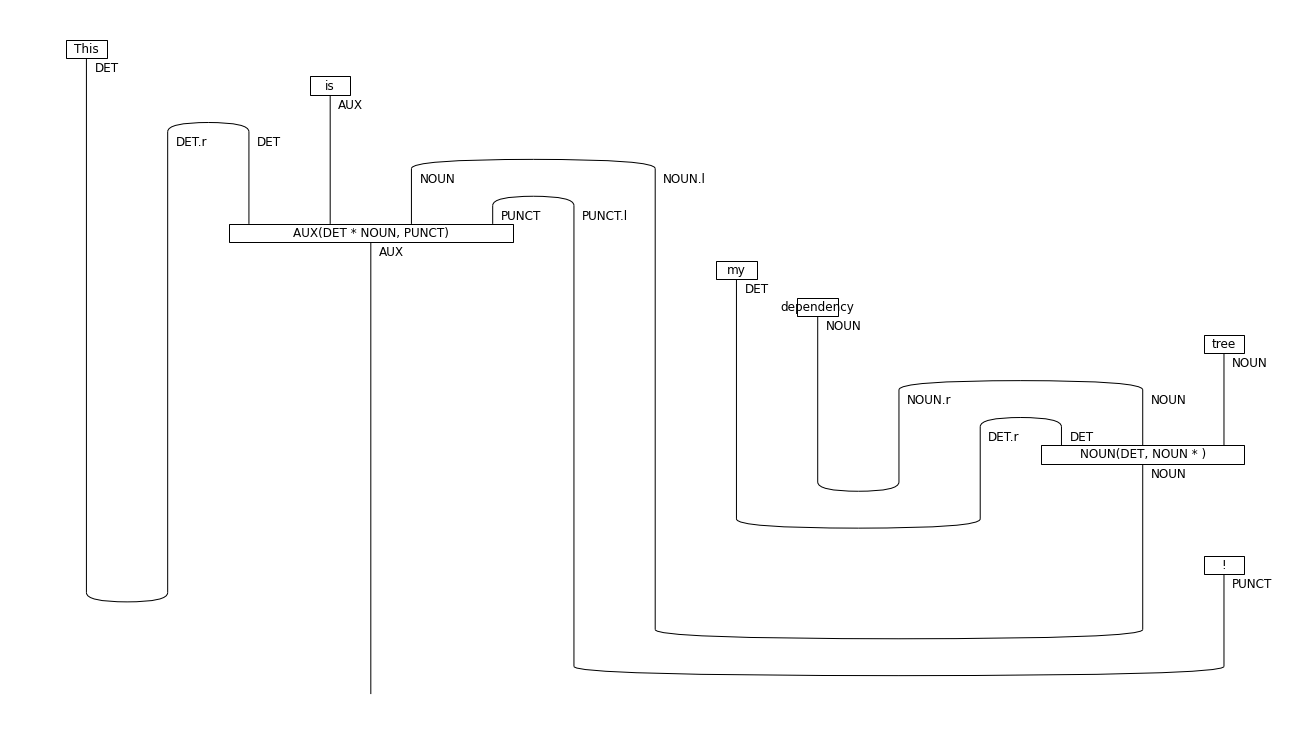

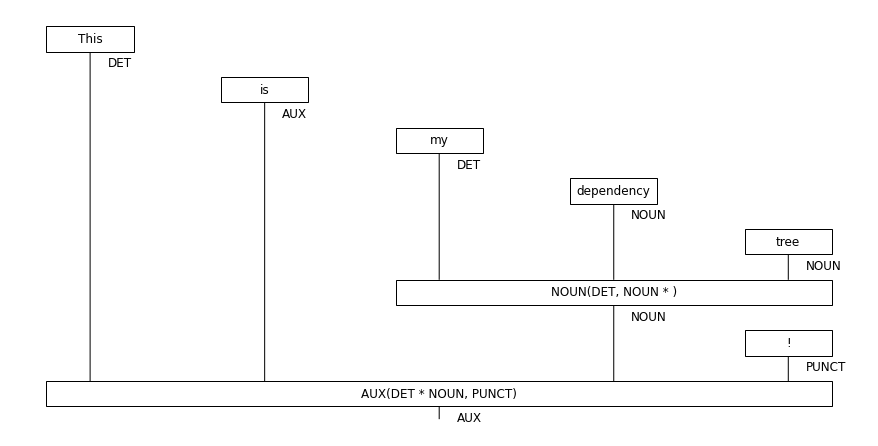

In [6]:
from discopy import Diagram

spacy_types = [
Ty('ADJ'),
Ty('ADP'),
Ty('ADV'),
Ty('AUX'),
Ty('CONJ'),
Ty('DET'),
Ty('INTJ'),
Ty('NOUN'),
Ty('NUM'),
Ty('PART'),
Ty('PRON'),
Ty('PROPN'),
Ty('PUNCT'),
Ty('SCONJ'),
Ty('SYM'),
Ty('VERB'),
Ty('X'),
Ty('SPACE'),
Ty('CCONJ')
]

ob = {ty: ty for ty in spacy_types}
add_caps_functor = Functor(ob, ar=add_caps_box, ob_factory=Ty, ar_factory=Diagram)

snakey = add_caps_functor(diagram)
snakey.draw(figsize=(18,10))
snakey.normal_form().draw(figsize=(12,6))

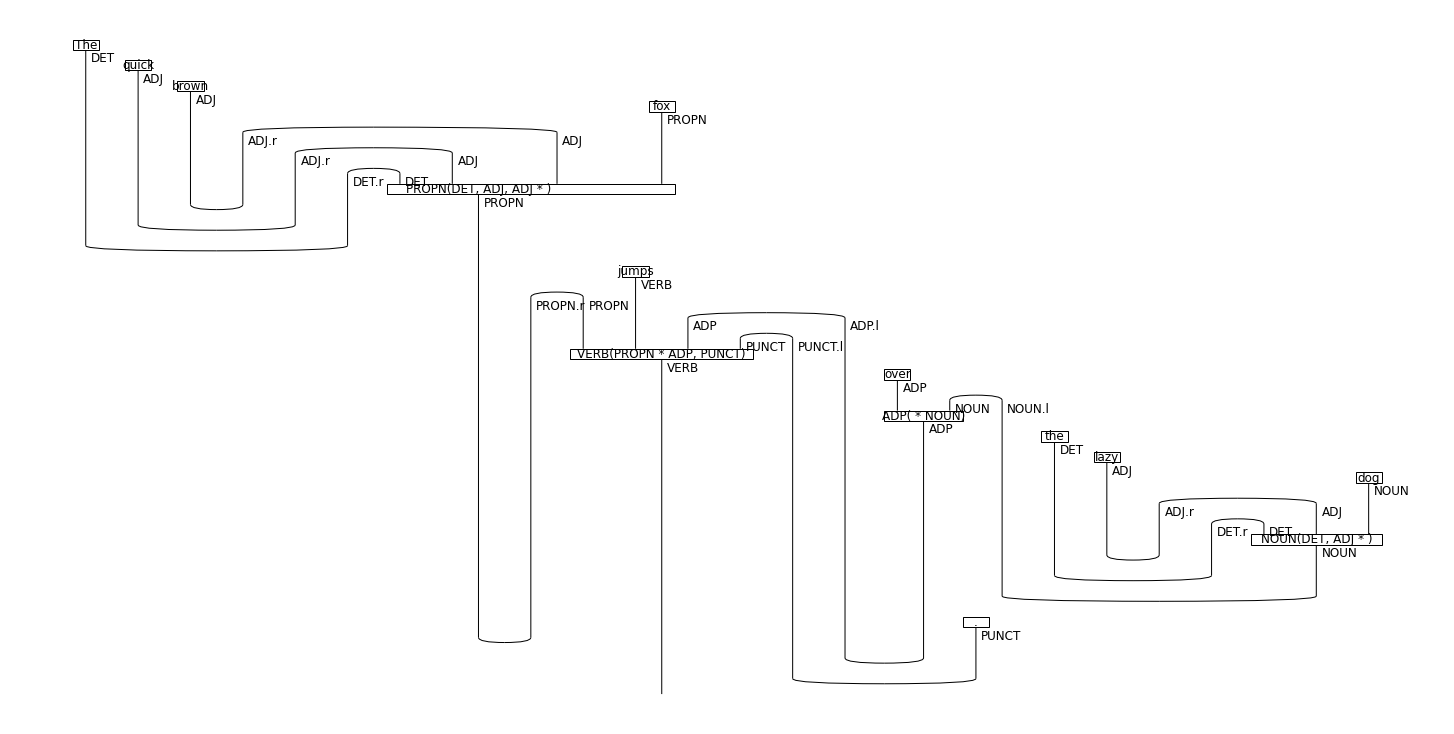

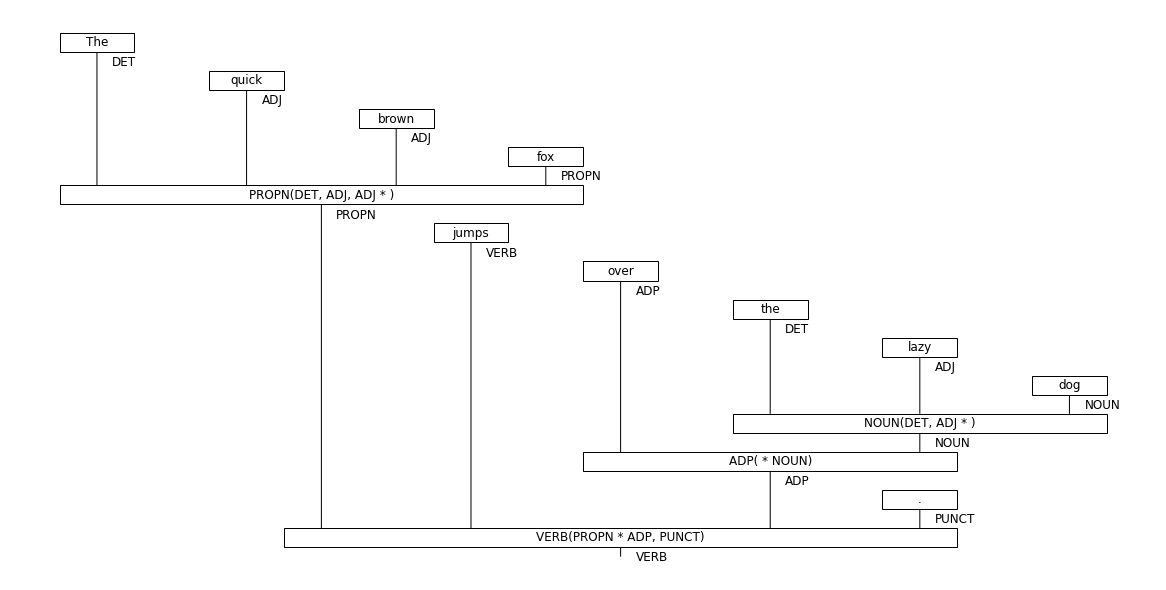

In [7]:
snakey2 = add_caps_functor(diagram2)
snakey2.draw(figsize=(20,10))
snakey2.normal_form().draw(figsize=(16,8))